# Imbalance Simulation Study (Sample Size) Companion to Paper: 
# Validating Machine-Learned Diagnostic Classifiers in Safety Critical Applications with Imbalanced Populations

## Code Author: Daniel Wade 
### United States Army, Aviation and Missile Research Development and Engineering Center
#### Companion Paper Co-Authors: Andrew Wilson, PhD; Abraham Reddy (Honeywell Aerospace); Raj Bharadwaj (Honeywell Aerospace) 
#### Under 17 U.S.C. 105, the United States Government does not hold any copyright in works produced by U.S. Government employees within the scope of their employment.
#### Distribution Statement A: For Public Release per AMRDEC PAO

### Abstract
Data science techniques such as machine learning are rapidly becoming available to engineers building models from system data, such as aircraft operations data. These techniques require validation for use in fielded systems providing recommendations to operators or maintainers. The methods for validating and testing machine learned algorithms generally focus on model performance metrics such as accuracy or F1-score. Many aviation datasets are highly imbalanced, which can invalidate some underlying assumptions of machine learning models. Two simulations are performed to show how some common performance metrics respond to imbalanced populations. The results show that each performance metric responds differently to a sample depending on the imbalance ratio between two classes. The results indicate that traditional methods for repairing underlying imbalance in the sample may not provide the rigorous validation necessary in safety critical applications.

The objective for sharing this notebook is to inspire other researchers and engineers to examine and understand the underlying assumptions made when a method is chosen for selecting a machine-learned model for an application.

#### Paper submitted to ASME V&V Symposium 2018; Paper ID VVS2018-9319

### References
1 Powers, David. “Evaluation: From Precision, Recall, and F-Measure to ROC, Informedness, Markedness & Correlation.” Journal of Machine Learning Technologies Vol. 2 No. 1 (2011): pp.37-63. DOI 10.9735/2229-3981.

2 Wilson, Andrew, Wade, Daniel, Albarado, Kevin, Partain, Jeremy and Statham, Matthew. “A Classifier Development Process for Mechanical Diagnostics on US Army Rotorcraft.” Proceedings of the 1st ML and PHM Workshop, SIGKDD 2016. San Francisco, CA, August 8-13, 2016. DOI 10.475/123_4. https://www.researchgate.net/publication/319879271_A_Classifier_Development_Process_for_Mechanical_Health_Diagnostics_on_US_Army_Rotorcraft

This simulation uses numpy sklearn pandas and matplotlib.pyplot. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')
%matplotlib inline


The next two definitions create a sample of size N from the rayleigh and normal distributions

In [2]:
def DiagnosticValueHumans(N_Humans,human_scale):
    sample_values = np.random.rayleigh(scale=human_scale,size=int(N_Humans))
    return sample_values
def DiagnosticValueZombies(N_Zombies,zombie_mean,zombie_scale):
    sample_values = np.random.normal(loc=zombie_mean,scale=zombie_scale,size=int(N_Zombies))
    return sample_values


The overarching function that does a single simulation is defined next. This function takes input from the user (sample size, number of zombies in the sample, and distribution setup parameters). It outputs the summary statistics in a dictionary which can be later used in a dataframe.

In [3]:
def SingleZombieSimulation(sample_size,N_Zombies,human_scale,zombie_mean,zombie_scale):
    # Define the first sample used to set the simulation start point
    N_Humans = sample_size - N_Zombies
    # Define diagnostic values for the whole sample
    Diagnostic_Values_Sample = np.concatenate((DiagnosticValueHumans(N_Humans,human_scale),DiagnosticValueZombies(N_Zombies,zombie_mean,zombie_scale)),axis=0)
    GroundTruth = np.concatenate((np.zeros(int(N_Humans)),np.ones(int(N_Zombies))),axis=0)
    # use the Roc Curve function to get a sweep of thresholds
    RC = roc_curve(GroundTruth,Diagnostic_Values_Sample)
    # the max of this vector is the best informedness and the position is the location in RC[2] for the associated threshold
    Best_Inf_Pos = np.argmax(RC[1]-RC[0]) 
    Best_Informedness = (RC[1]-RC[0])[Best_Inf_Pos]
    # Initialize some variables
    F1SCORE = np.zeros(len(RC[2]))
    ACC = np.zeros(len(RC[2]))
    WACC = np.zeros(len(RC[2]))
    # Setup the weights for weighted accuracy
    WeightVector = np.zeros(len(GroundTruth))
    Weights = [1/(2.0*N_Humans),1/(2.0*N_Zombies)]
    for m in range(len(GroundTruth)):
        if GroundTruth[m] == 0.0:
            WeightVector[m] = Weights[0]
        else:
            WeightVector[m] = Weights[1]
    # Iterate over the thresholds to find results for F1, Accuracy, and Weighted Accuracy
    counter = 0
    for m in RC[2]:
        Predictor_alpha = np.zeros(int(sample_size))
        for n in np.arange(0,len(Predictor_alpha)):
            if Diagnostic_Values_Sample[n] > m:
                Predictor_alpha[n] = 1.0
        F1SCORE[counter] = f1_score(GroundTruth,Predictor_alpha)
        ACC[counter] = accuracy_score(GroundTruth,Predictor_alpha)
        WACC[counter] = accuracy_score(GroundTruth,Predictor_alpha,sample_weight=WeightVector)
        counter = counter + 1
    # Get the summary results together
    Best_F1SCORE = F1SCORE[F1SCORE.argmax()]
    Best_ACC = ACC[ACC.argmax()]
    Best_WACC = WACC[WACC.argmax()]
    SummaryOutput = dict(zip(['N Zombies','Sample Size','Acc Threshold','Acc TPR','Acc TPs','Acc FPR','Acc FPs','F1 Threshold','F1 TPR','F1 TPs','F1 FPR','F1 FPs',
    'Inf Threshold','Inf TPR','Inf TPs','Inf FPR','Inf FPs','WAcc Threshold','WAcc TPR','WAcc TPs','WAcc FPR','WAcc FPs'],
    [N_Zombies,sample_size,RC[2][ACC.argmax()],RC[1][ACC.argmax()],RC[1][ACC.argmax()]*N_Zombies,RC[0][ACC.argmax()],RC[0][ACC.argmax()]*N_Humans,
    RC[2][F1SCORE.argmax()],RC[1][F1SCORE.argmax()],RC[1][F1SCORE.argmax()]*N_Zombies,RC[0][F1SCORE.argmax()],RC[0][F1SCORE.argmax()]*N_Humans,
    RC[2][Best_Inf_Pos],RC[1][Best_Inf_Pos],RC[1][Best_Inf_Pos]*N_Zombies,RC[0][Best_Inf_Pos],RC[0][Best_Inf_Pos]*N_Humans,
    RC[2][WACC.argmax()],RC[1][WACC.argmax()],RC[1][WACC.argmax()]*N_Zombies,RC[0][WACC.argmax()],RC[0][WACC.argmax()]*N_Humans]))
    return SummaryOutput

The last function needed to run the simulation grows the sample size. This outputs a list that can be iterated through in the above simulation definition.

In [4]:
def NextSample(sample_size_low,sample_size_high):
    output = list()
    output.append(sample_size_low)
    output.append(sample_size_low + 500.0)
    while output[-1] <= sample_size_high:
        output.append(output[-1]+output[-2])
    return(output)

# Calling the Functions and Completing a Simulation
The following code blocks run the simulation. The first block contains all of the variables you will need to adjust.
The number of zombies in the sample is controlled by a ratio, 
#### zombie imbalance factor: (Initial Zombies)/(Initial Sample Size), 

in the case shown, we use 1/500. It is grown using the following equation:

#### (number of zombies in the current sample)/(current sample size) = (Initial Zombies)/(Initial Sample Size)

In [5]:
SimulationSummaryOutput = list()
ZombieImbalanceFactor = 1/500.0
sample_size_low = 1000.0
sample_size_high = 50000.0
sample_vector = NextSample(sample_size_low,sample_size_high)
human_scale=3.0
zombie_scale=2.0
zombie_mean=10.5
simulation_file = 'C:\\SimulationData\\FileName.hdf5'
simulation_key = 'Sample_Size_Simulation'
number_of_simulations = 1000

In [6]:
for sample_size in sample_vector:
    for n in np.arange(0,number_of_simulations,1):
        N_Zombies = np.floor(sample_size*ZombieImbalanceFactor)
        Summary = SingleZombieSimulation(sample_size,N_Zombies,human_scale,zombie_mean,zombie_scale)
        SimulationSummaryOutput.append(Summary)
    message = 'Number of Zombies: '
    print('Number of Zombies: ',N_Zombies)
    print('Number of samples: ',sample_size)
    SimulationSummaryDF = pd.DataFrame(SimulationSummaryOutput)
#SimulationSummaryDF.to_hdf(simulation_file,simulation_key)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Number of Zombies:  2.0
Number of samples:  1000.0
Number of Zombies:  3.0
Number of samples:  1500.0
Number of Zombies:  5.0
Number of samples:  2500.0
Number of Zombies:  8.0
Number of samples:  4000.0
Number of Zombies:  13.0
Number of samples:  6500.0
Number of Zombies:  21.0
Number of samples:  10500.0
Number of Zombies:  34.0
Number of samples:  17000.0
Number of Zombies:  55.0
Number of samples:  27500.0
Number of Zombies:  89.0
Number of samples:  44500.0
Number of Zombies:  144.0
Number of samples:  72000.0


Now we need to make plots. Here is some code that will aggregate the results and compute the absolute errors.

In [7]:
means = SimulationSummaryDF.groupby('Sample Size').aggregate(np.mean)
stds = SimulationSummaryDF.groupby('Sample Size').aggregate(np.std)
    
AccErrorRate = (means['Acc FPs'].values+means.index-means['Acc TPs'].values)/sample_size
AccErrorRateSTD = (stds['Acc FPs'].values+stds.index-stds['Acc TPs'].values)/sample_size
WAccErrorRate = (means['WAcc FPs'].values+means.index-means['WAcc TPs'].values)/sample_size
WAccErrorRateSTD = (stds['WAcc FPs'].values+stds.index-stds['WAcc TPs'].values)/sample_size
F1ErrorRate = (means['F1 FPs'].values+means.index-means['F1 TPs'].values)/sample_size
F1ErrorRateSTD = (stds['F1 FPs'].values+stds.index-stds['F1 TPs'].values)/sample_size
InfErrorRate = (means['Inf FPs'].values+means.index-means['Inf TPs'].values)/sample_size


# Plot the Results
The first two plots look at the True Positive Rate, and False Positive Rate.
The third looks at the Threshold for each method.

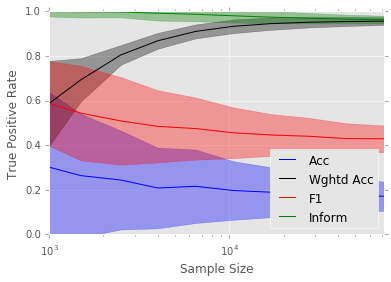

In [20]:
f13 = plt.figure(13)
plt.semilogx(means.index,means['Acc TPR'].values,color='b',label='Acc')
plt.fill_between(means.index,means['Acc TPR'].values+stds['Acc TPR'].values,means['Acc TPR'].values-stds['Acc TPR'].values,color='b',alpha=0.35)
plt.semilogx(means.index,means['WAcc TPR'].values,color='k',label='Wghtd Acc')
plt.fill_between(means.index,means['WAcc TPR'].values+stds['WAcc TPR'].values,means['WAcc TPR'].values-stds['WAcc TPR'].values,color='k',alpha=0.35)
plt.semilogx(means.index,means['F1 TPR'].values,color='r',label='F1')
plt.fill_between(means.index,means['F1 TPR'].values+stds['F1 TPR'].values,means['F1 TPR'].values-stds['F1 TPR'].values,color='r',alpha=0.35)
plt.semilogx(means.index,means['Inf TPR'].values,color='g',label='Inform')
plt.fill_between(means.index,means['Inf TPR'].values+stds['Inf TPR'].values,means['Inf TPR'].values-stds['Inf TPR'].values,color='g',alpha=0.35)
plt.ylim(0.0,1.0)
plt.xlim(1000,72000)
plt.legend(loc=4)
#plt.title('TPR as a Function of Sample Size',fontdict={'fontsize':8,'fontweight':3})
plt.xlabel('Sample Size')
plt.ylabel('True Positive Rate')
#plt.savefig('C:\\SimulationData\\True Positive Rate.png',dpi=300,bbox_inches='tight')

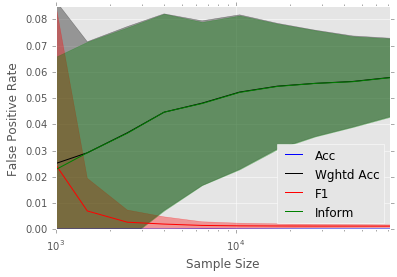

In [17]:
f14 = plt.figure(14)
plt.semilogx(means.index,means['Acc FPR'].values,color='b',label='Acc')
plt.fill_between(means.index,means['Acc FPR'].values+stds['Acc FPR'].values,means['Acc FPR'].values-stds['Acc FPR'].values,color='b',alpha=0.35)
plt.semilogx(means.index,means['WAcc FPR'].values,color='k',label='Wghtd Acc')
plt.fill_between(means.index,means['WAcc FPR'].values+stds['WAcc FPR'].values,means['WAcc FPR'].values-stds['WAcc FPR'].values,color='k',alpha=0.35)
plt.semilogx(means.index,means['F1 FPR'].values,color='r',label='F1')
plt.fill_between(means.index,means['F1 FPR'].values+stds['F1 FPR'].values,means['F1 FPR'].values-stds['F1 FPR'].values,color='r',alpha=0.35)
plt.semilogx(means.index,means['Inf FPR'].values,color='g',label='Inform')
plt.fill_between(means.index,means['Inf FPR'].values+stds['Inf FPR'].values,means['Inf FPR'].values-stds['Inf FPR'].values,color='g',alpha=0.35)
plt.ylim(0.0,0.085)
plt.xlim(1000,72000)
plt.legend(loc=4)
#plt.title('FPR as a Function of Sample Size',fontdict={'fontsize':8,'fontweight':3})
plt.xlabel('Sample Size')
plt.ylabel('False Positive Rate')
#plt.savefig('C:\\SimulationData\\False Positive Rate.png',dpi=300,bbox_inches='tight')

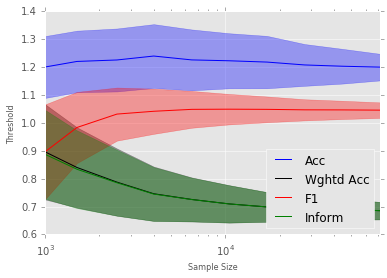

In [18]:
f15 = plt.figure(15)
plt.semilogx(means.index,means['Acc Threshold'].values/zombie_mean,color='b',label='Acc')
plt.fill_between(means.index,means['Acc Threshold'].values/zombie_mean+stds['Acc Threshold'].values/zombie_mean,means['Acc Threshold']/zombie_mean-stds['Acc Threshold']/zombie_mean,color='b',alpha=0.35)
plt.semilogx(means.index,means['WAcc Threshold'].values/zombie_mean,color='k',label='Wghtd Acc')
plt.fill_between(means.index,means['WAcc Threshold'].values/zombie_mean+stds['WAcc Threshold'].values/zombie_mean,means['WAcc Threshold'].values/zombie_mean-stds['WAcc Threshold'].values/zombie_mean,color='k',alpha=0.35)
plt.semilogx(means.index,means['F1 Threshold'].values/zombie_mean,color='r',label='F1')
plt.fill_between(means.index,means['F1 Threshold'].values/zombie_mean+stds['F1 Threshold'].values/zombie_mean,means['F1 Threshold'].values/zombie_mean-stds['F1 Threshold'].values/zombie_mean,color='r',alpha=0.35)
plt.semilogx(means.index,means['Inf Threshold'].values/zombie_mean,color='g',label='Inform')
plt.fill_between(means.index,means['Inf Threshold'].values/zombie_mean+stds['Inf Threshold'].values/zombie_mean,means['Inf Threshold'].values/zombie_mean-stds['Inf Threshold'].values/zombie_mean,color='g',alpha=0.35)
plt.xlim(1000,72000)
plt.legend(loc=4)
#plt.title('Normalized Threshold as a Function of Sample Size',fontdict={'fontsize':8,'fontweight':3})
plt.xlabel('Sample Size',fontdict={'fontsize':8,'fontweight':3})
plt.ylabel('Threshold',fontdict={'fontsize':8,'fontweight':3})
#plt.savefig('C:\\SimulationData\\Threshold.png',dpi=300,bbox_inches='tight')